<a href="https://colab.research.google.com/github/peterX96/MLDM-2023-Gorovtsov/blob/main/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

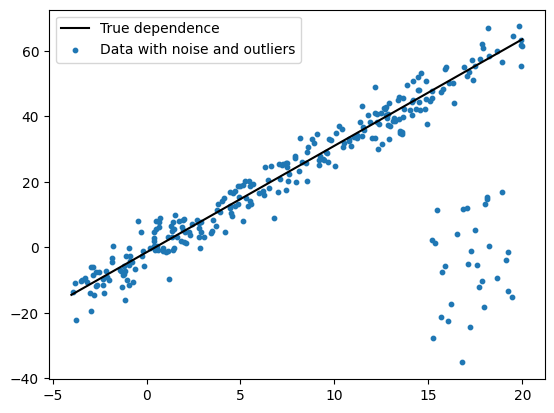

In [4]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

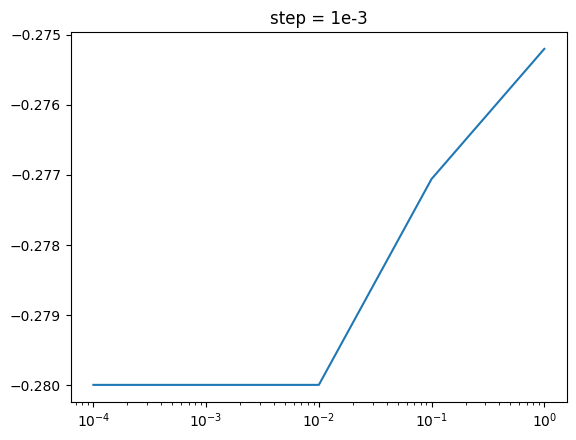

In [75]:
def get_MAE(X, w, y):
    return (np.sum(np.abs((np.concatenate((X, np.ones_like(X)), axis = 1)@w - y))))/y.shape[0]

def grad_get_MAE(X, w, y, step):
    step_mat = step*np.eye(w.shape[0])
    return np.array([(get_MAE(X, w + step_mat[i], y) -  get_MAE(X, w - step_mat[i], y))/(2*step) for i in range(w.shape[0])])

#посмотрим, где значение функции выходит на константу и так определим оптимальный шаг для численного дифференцирования

a = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1])
b = [grad_get_MAE(X, w, y, aa)[1] for aa in a]

plt.plot(a, b)
plt.title('step = 1e-3')
plt.xscale('log')

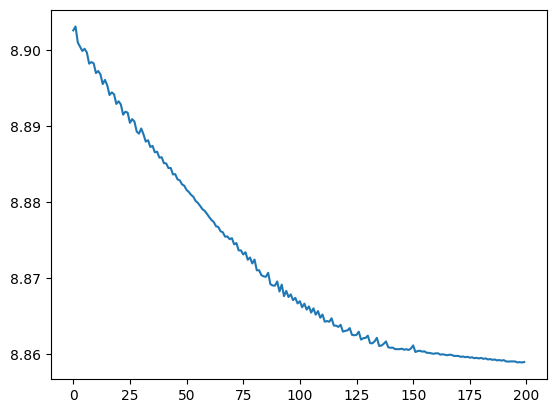

In [132]:
#сам спуск
w = np.array([3, 0])
MAE_list = []
grad_step = 1e-3
alpha = 0.1
Nsteps = 200
w_story = np.empty((Nsteps, 2))
for i in range(Nsteps):
    grad = grad_get_MAE(X, w, y, grad_step)
    w = w - alpha*grad
    w_story[i] = w
    MAE_list.append(get_MAE(X, w, y))

plt.plot(range(Nsteps), MAE_list)
#plt.yscale('log')

True parameters are  3.75 -1.47


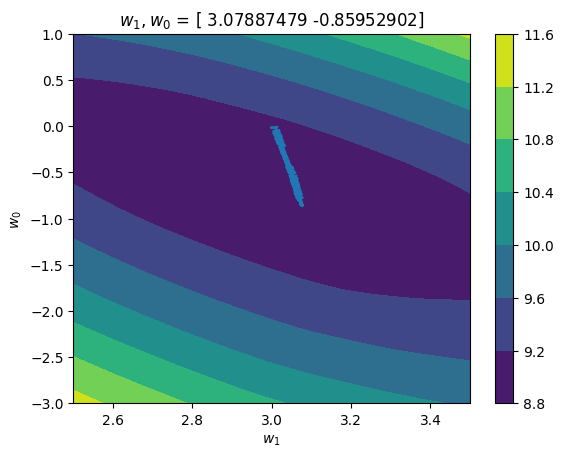

In [138]:
accuracy = 100
lin1, lin2 = np.linspace(2.5, 3.5, accuracy), np.linspace(-3, 1, accuracy)

loss_map = np.empty((accuracy, accuracy))
for i in range(accuracy):
    for j in range(accuracy):
        loss_map[i, j] = get_MAE(X, np.array((lin1[i], lin2[j])), y)

ww1, ww2 = np.meshgrid(lin1, lin2)
plt.title(r'$w_1, w_0$ = ' + str(w))
plt.contourf(ww1, ww2, loss_map)
plt.plot(w_story[:, 0], w_story[:, 1])
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_0$')
plt.colorbar();
print('True parameters are ', 3.75, -1.47)

[2.05001443] 1.862639265305102


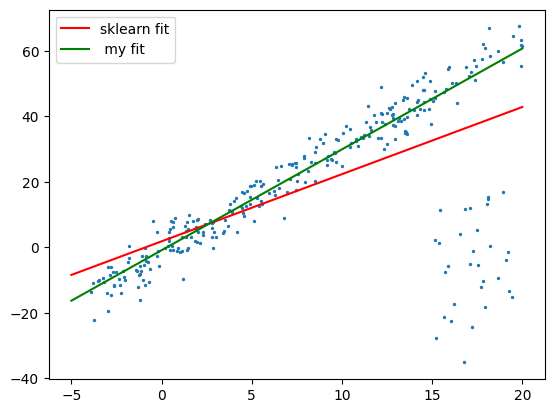

In [141]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

x = np.linspace(-5, 20, 2)
plt.plot(x, x*model.coef_ + model.intercept_, label='sklearn fit', color = 'red')
plt.scatter(X, y, s = 2);
plt.plot(x, w[0]*x + w[1], label=' my fit', color = 'green')
plt.legend()

print(model.coef_, model.intercept_)

Видно, что фит sklearn работает хуже, чем наш, потому что евклидова метрика более чувствительна к выбросам, чем используемая нами. Наш результат можно сделать ещё менее чувствительным к выбросам, если заменить get_MAE на max(get_MAE, therchold), где treshold задаёт масштаб шумов на данных (например, число 15)

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [143]:
from sklearn.base import BaseEstimator, RegressorMixin

In [184]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    def __init__(self, gradient_step, alpha, stop_parameter, w_start = np.array([0, 0]), loss_function = get_MAE):
        self.loss_function = loss_function #loss_function takes arguments like X, w, y
        self.gradient_step = gradient_step
        self.alpha = alpha
        self.w_start = w_start
        self.w_predicted = np.empty(2)
        self.stop_parameter = stop_parameter

    def fit(self, x, y):
        def loss_grad(X, w, y, step):
            step_mat = step*np.eye(w.shape[0])
            grad = np.zeros(w.shape)
            i = np.random.randint(0, w.shape)
            grad[i] = (self.loss_function(X, (w + step_mat[i])[0], y) -  self.loss_function(X, (w - step_mat[i])[0], y))/(2*step)
            return grad

        w = self.w_start.copy()
        while True:
            prev_w = w.copy()
            w = w - alpha*loss_grad(x, w, y, self.gradient_step)
            if np.linalg.norm(w-prev_w) < self.stop_parameter:
                break
        self.w_predicted = w

    def predict(self, x):
        return np.concatenate((x, np.ones_like(x)), axis = 1)@self.w_predicted

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

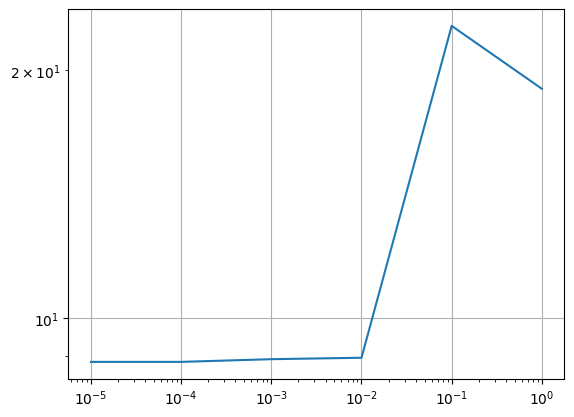

In [221]:
stop_parameters = np.logspace(0, -5, 6)#np.array([1e-7, 1e-5, 1e-3, 1e-1])
loss_list = np.empty(len(stop_parameters))
loss_function = get_MAE

for i in range(len(stop_parameters)):
    model = LinearRergessionSGD(1e-3, 0.2, stop_parameters[i])
    model.fit(X, y)
    loss_list[i] = loss_function(X, model.w_predicted, y)

plt.plot(stop_parameters, loss_list)
plt.xscale('log')
plt.yscale('log')
plt.grid()

[ 3.07692374 -0.91583677]


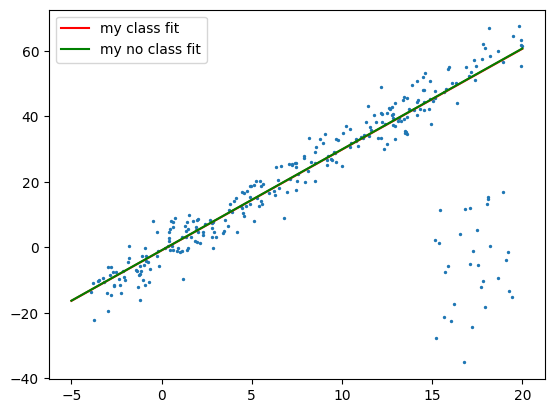

In [222]:
x = np.linspace(-5, 20, 2)
plt.plot(x, np.concatenate((x[:, None], np.ones_like(x)[:, None]), axis = 1)@model.w_predicted, label='my class fit', color = 'red')
plt.scatter(X, y, s = 2);
plt.plot(x, w[0]*x + w[1], label='my no class fit', color = 'green')
plt.legend()

print(model.w_predicted)

Итак, результаты совпали, чего и следовало ожидать